# Seminar 8

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

from mlxtend.plotting import plot_decision_regions

## Decision trees

![](https://drive.google.com/uc?id=13kmqLXa-3FBUJq0Q3XVOkz8TENpVTkqk)

### Decision trees vs linear models

Let's check some synthetic data to understand which model (decision tree or logistic regression) wins.

In [ ]:
np.random.seed(13)
n = 500
X = np.zeros(shape=(n, 2))
X[:, 0] = np.linspace(-5, 5, 500)
X[:, 1] = X[:, 0] + 0.5 * np.random.normal(size=n)
y = (X[:, 1] > X[:, 0]).astype(int)
plt.scatter(X[:, 0], X[:, 1], s=100, c=y);

The data seems to be linearly separated, let's fit linear regression nd test it:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=13
)

lr = LogisticRegression(random_state=13)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print(f"Linear model accuracy: {accuracy_score(y_pred_lr, y_test):.2f}")
plot_decision_regions(X_test, y_test, lr);

Cool, what about a decision tree?

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=13)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print(f"Decision tree accuracy: {accuracy_score(y_pred_dt, y_test):.2f}")
plot_decision_regions(X_test, y_test, dt);

Worse. What about other data?

In [ ]:
np.random.seed(13)
X = np.random.randn(500, 2)
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0).astype(int)
plt.scatter(X[:, 0], X[:, 1], s=100, c=y);

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=13
)

lr = LogisticRegression(random_state=13)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print(f"Linear model accuracy: {accuracy_score(y_pred_lr, y_test):.2f}")

plot_decision_regions(X_test, y_test, lr);

In [ ]:
dt = DecisionTreeClassifier(random_state=13)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print(f"Linear model accuracy: {accuracy_score(y_pred_dt, y_test):.2f}")

plot_decision_regions(X_test, y_test, dt);

And on this data decision tree wins.

**Conclusion:** best model depends on data.

### Overfitting

Again, some synthetic data. This data is harder, because there is a significant overlap of classes.

In [ ]:
np.random.seed(13)
n = 100
X = np.random.normal(size=(n, 2))
X[:50, :] += 0.25
X[50:, :] -= 0.25
y = np.array([1] * 50 + [0] * 50)
plt.scatter(X[:, 0], X[:, 1], s=100, c=y);

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))

for i, max_depth in enumerate([3, 5, None]):
    for j, min_samples_leaf in enumerate([15, 5, 1]):
        dt = DecisionTreeClassifier(
            max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=13
        )
        dt.fit(X, y)
        ax[i][j].set_title(
            "max_depth = {} | min_samples_leaf = {}".format(max_depth, min_samples_leaf)
        )
        ax[i][j].axis("off")
        plot_decision_regions(X, y, dt, ax=ax[i][j])

plt.show()

If there are no contradicting data (same features, different target), we can achieve the best possible quality of model on train data (accuracy=1, MSE=0)

In [ ]:
dt = DecisionTreeClassifier(max_depth=None, min_samples_leaf=1, random_state=13)
dt.fit(X, y)

print(f"Decision tree accuracy: {accuracy_score(y, dt.predict(X)):.2f}")

plot_decision_regions(X, y, dt);

### Instability

Let's conduct an experiment: we will use random 90\% of our data and fit the decision tree. Will if change a lot?

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))

for i in range(3):
    for j in range(3):
        seed_idx = 3 * i + j
        np.random.seed(seed_idx)
        dt = DecisionTreeClassifier(random_state=13)
        idx_part = np.random.choice(len(X), replace=False, size=int(0.9 * len(X)))
        X_part, y_part = X[idx_part, :], y[idx_part]
        dt.fit(X_part, y_part)
        ax[i][j].set_title("sample #{}".format(seed_idx))
        ax[i][j].axis("off")
        plot_decision_regions(X_part, y_part, dt, ax=ax[i][j])

plt.show()

The plot changes a lot, let's also check if logistic regression changes a lot, too:

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))

for i in range(3):
    for j in range(3):
        seed_idx = 3 * i + j
        np.random.seed(seed_idx)
        dt = LogisticRegression(random_state=13)
        idx_part = np.random.choice(len(X), replace=False, size=int(0.9 * len(X)))
        X_part, y_part = X[idx_part, :], y[idx_part]
        dt.fit(X_part, y_part)
        ax[i][j].set_title("sample #{}".format(seed_idx))
        ax[i][j].axis("off")
        plot_decision_regions(X_part, y_part, dt, ax=ax[i][j])

plt.show()

### Visualization

In [ ]:
dt = DecisionTreeClassifier(max_depth=3, min_samples_leaf=3, random_state=13)
dt.fit(X, y)

In [ ]:
from sklearn.tree import plot_tree

plot_tree(dt, filled=True, rounded=True);

### Iris dataset

Let's work with [Iris dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set) again and solve the binary classification problem:  versicolor (class 1) will be +1 and setosa, virginica (classes 0, 2) will be 0.

In [ ]:
data = load_iris()

X = pd.DataFrame(data['data'], columns = data['feature_names'])[['sepal length (cm)', 'sepal width (cm)']]
y = data['target'].copy()
y[y!=1] = 0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)

Let's fit logistic regression:

In [ ]:
from sklearn.linear_model import LogisticRegression

params = {'C' : np.logspace(-12, 10, 30)}

lr = GridSearchCV(LogisticRegression(),
                   params, cv=3,
                   scoring='accuracy'
                   )
lr.fit(X_train, y_train)

In [ ]:
print(accuracy_score(y_test,  lr.predict(X_test)))

plot_decision_regions(X_test.values, y_test, clf=lr);

In [ ]:
params = {'max_depth' : [1, 2, 5, 10, None],
          'min_samples_split':[2, 5, 10],
          'min_samples_leaf':[1, 2, 3, 4]}

tree = GridSearchCV(DecisionTreeClassifier(),
                   params, cv=3,
                   scoring='accuracy'
                   )
tree.fit(X_train, y_train)

In [ ]:
print(accuracy_score(y_test,  tree.predict(X_test)))

plot_decision_regions(X_test.values, y_test, clf=tree);

## k-nearest neighbors

We have linear regression for regression and logistic regression for classification. (also you may have already encountered decision trees).

There is another machine learning algorithm that may be useful: k-nearest neighbors (kNN)

Algorithm:



*   Hyperparameter: k (number of nearest neighbors to check)
*   Trainig: save all the training sample, no coefficients to estimate
*   Predicting: for the new sample find k nearest from the training set. Return the most popular class (classification task), or mean target (regression)

Why does it work? Usually, samples with similar target values are near each other, if we check the neighbors of a point we get some idea about the target of it.



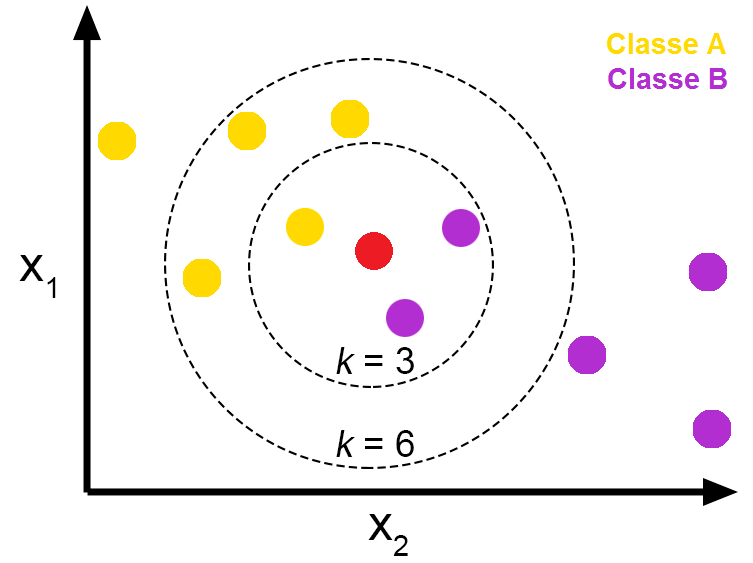

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

print(accuracy_score(y_test,  knn.predict(X_test)))
plot_decision_regions(X_test.values, y_test, clf=knn)

The plot is more complex, because there the decision boundary is not a line

In [ ]:
params = {'n_neighbors' : [1, 3, 5, 10, 20, 25, 30, 50]}

knn = GridSearchCV(KNeighborsClassifier(),
                   params, cv=3,
                   scoring='accuracy'
                   )
knn.fit(X_train, y_train)

In [ ]:
print(accuracy_score(y_test,  knn.predict(X_test)))
plot_decision_regions(X_test.values, y_test, clf=knn)

## Classification metrics

The KNN algorithm seems to demonstrate better quality than logistic regression, tree and random classifier (~0.5 accuracy).

What if we just predict the modet popular class? (Always one class)

In [ ]:
labels, counts = np.unique(y_train, return_counts=True)
most_popular_class = labels[counts.argmax()]

most_popular_class

In [ ]:
print(accuracy_score(y_test,  most_popular_class * np.ones(len(y_test))))

We may notice possible problem: accuracy is not bad if we predict like this. We do not learn any dependencies, or predict both classes but still get ok accuracy.

What if the situation was extreme?

Example:

we are trying to predict some rare disease, there are 1000 patients, 1 is ill (class 1) and 999 are healthy (class 0).

Let's use same strategy:

In [ ]:
y_example = np.zeros(1000)
y_example[0] = 1

labels, counts = np.unique(y_example, return_counts=True)
most_popular_class = labels[counts.argmax()]

y_example_pred = most_popular_class * np.ones(len(y_example))

print(accuracy_score(y_example, y_example_pred))

The accuracy seems to be huge! The model is right in 99.9\% cases, but in reality it is useless.


Accuracy has problems, if the data is not balanced. Let's discuss some other metrics.

### Confusion Matrix



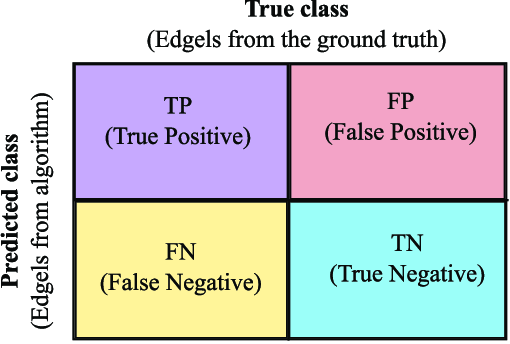

We can actually formulate accuracy using confusion matrix:



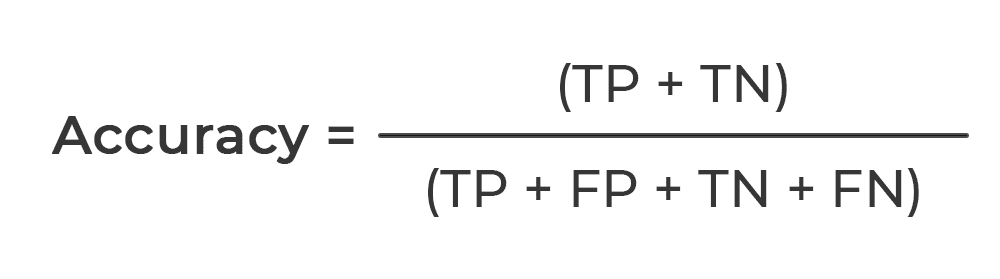

In [ ]:
from sklearn.metrics import confusion_matrix

def accuracy(y, p):
    (TN, FP), (FN, TP) = confusion_matrix(y, p)
    return (TN + TP) / (TN + FP + FN + TP)

In [ ]:
accuracy(y_example, y_example_pred)

There are other metrics:

Precision is the fraction of correctly classified as class 1 among the all classified as class 1 objects

Recall is the fraction of correctly classified as class 1 among the all class 1 objects


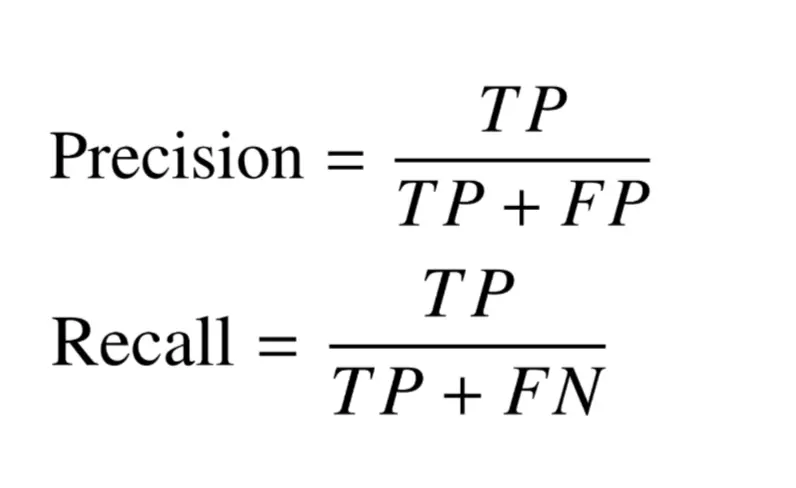

Precision and recall are from 0 to 1 (closer to 1 the better).

In [ ]:
def precision(y, p):
    (TN, FP), (FN, TP) = confusion_matrix(y, p)

    return TP / (TP + FP)

def recall(y, p):
    (TN, FP), (FN, TP) = confusion_matrix(y, p)

    return TP / (TP + FN)

For our example, it is impossible to compute precision (bacause $TP = FP = 0$). It means that our prediction is very bad.

In [ ]:
precision(y_example, y_example_pred)

Recall will be 0, because $TP = 0$

In [ ]:
recall(y_example, y_example_pred)

However, the metrics are still one-sided: if we classify everything with class 1 we will get ideal recall

In [ ]:
recall(y_example, np.ones(len(y_example))), precision(y_example, np.ones(len(y_example)))

We can combine them:



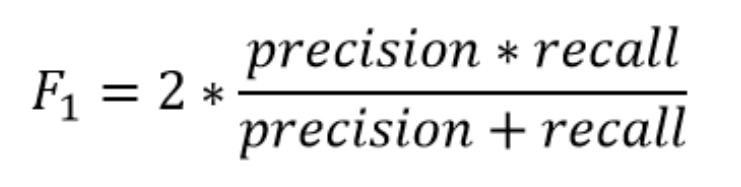

In [ ]:
def f1(y, p):
    re = recall(y, p)
    pr = precision(y, p)

    return 2 * pr * re / (pr + re)

In [ ]:
f1(y_example, y_example_pred)

Why not just arithmetic mean? Why harmonic?

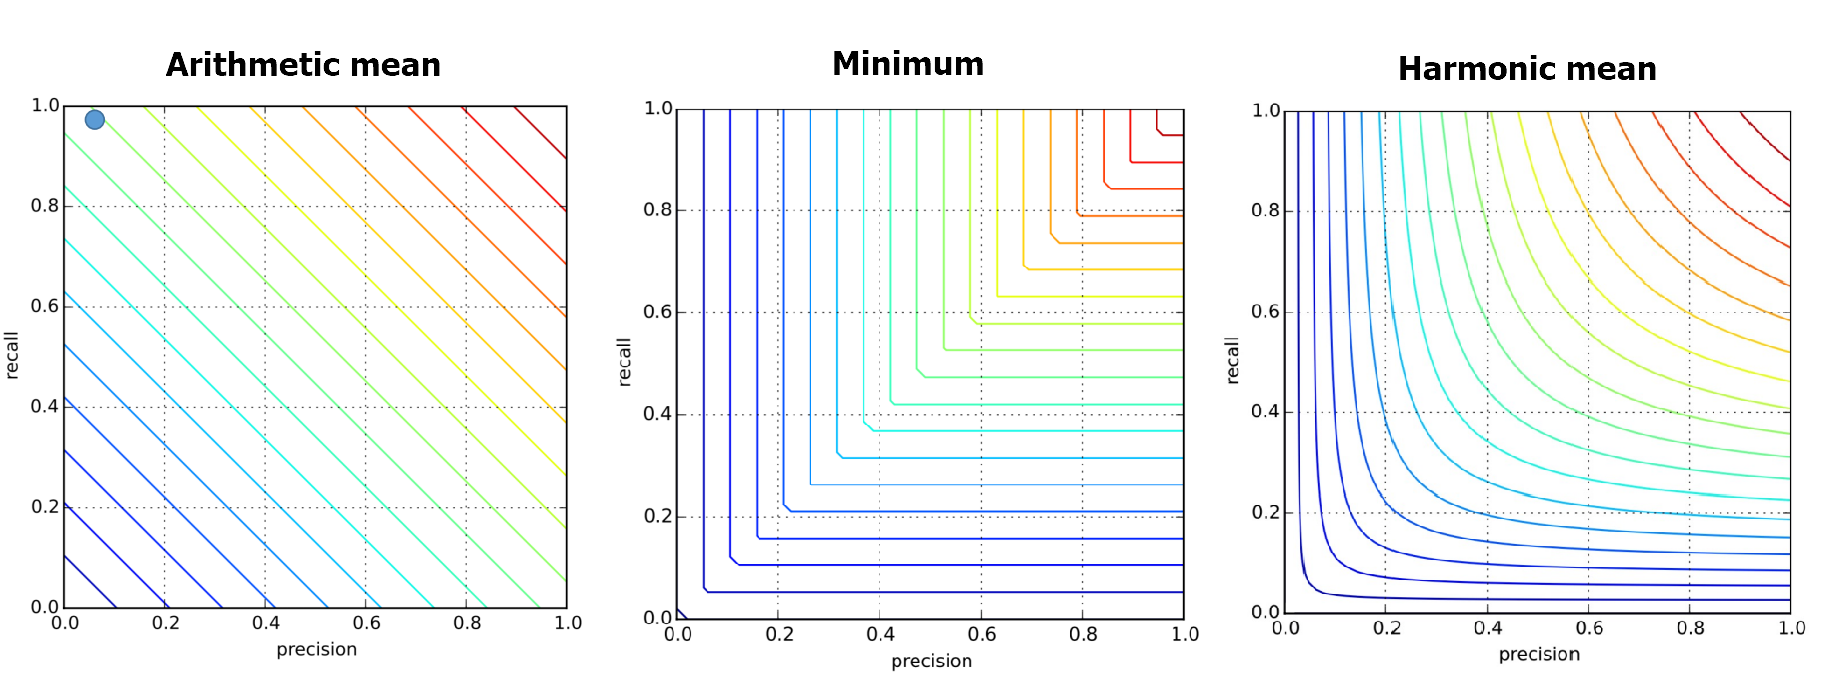

Example: ideal precision, very bad recall -> arithmetic mean is ok, but the harmonic is very bad.

In [ ]:
precision_example = 1.0
recall_example = 0.05

print('Arithmetic mean:', (precision_example + recall_example) / 2)
print('Harmonic mean  :', 2 * precision_example * recall_example / (precision_example + recall_example))

Let's compute metrics for our classifiers:

In [ ]:
metric_dict = {"Accuracy": accuracy,
               "Precision": precision,
               "Recall": recall,
               "F1-score": f1}

print('Logistic regression')
for title, func in metric_dict.items():
    print(title, func(y_test,  lr.predict(X_test)))


print('KNN')
for title, func in metric_dict.items():
    print(title, func(y_test,  knn.predict(X_test)))


print('Decision tree')
for title, func in metric_dict.items():
    print(title, func(y_test,  tree.predict(X_test)))

### ROC AUC

Previous metrics: for predictions of class (+1/0)

But how about probabilities? How to measure if they are good?

Answer: ROC AUC (Area Under the Receiver Operating Characteristic Curve)

Idea: let's draw a curve that depicts how good are the predicted probabilities and compute the area under it.

If the probabilities are ideal, ROC AUC = 1.0;

If the probabilities are very bad, ROC AUC = 0.0

If the probabilities are 0.5 (random classifier), ROC AUC = 0.5

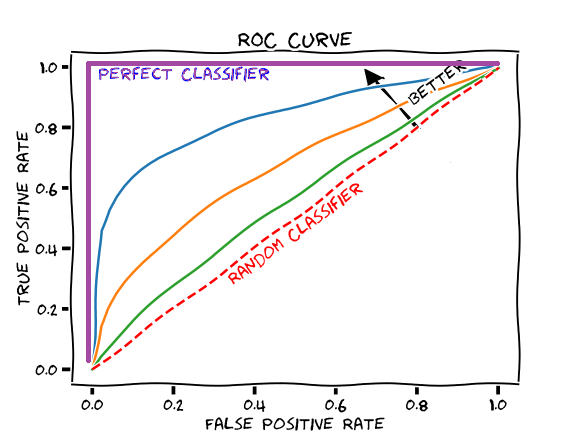

How to build the curve?

$$
TPR \text{ (true positive rate, recall, sensitivity)} = \dfrac{TP}{TP + FN}
$$
– fraction of correctly classified objects of class 1.

$$
FPR \text{ (false positive rate, 1 - specificity)} = \dfrac{FP}{FP + TN}
$$
– fraction of incorrectly classified objects of class 0.


Initially, the model gives us probabilities ($p$) and if $p \ge 0.5$ -class 1 and if $p \le 0.5$ - class 0.

Let's check other thresholds, not just $0.5$, for each compute TPR, FPR and depict on a plot.


In [ ]:
knn_proba = knn.predict_proba(X_test) [:, 1]

#add too big and too small threshold
thresholds = [-0.1] + np.sort(np.unique(knn_proba)).tolist() + [1.1]

fpr_list, tpr_list = [], []

for threshold in thresholds:
  (TN, FP), (FN, TP) = confusion_matrix(y_test, (knn_proba >= threshold).astype(int))
  fpr_list.append(FP / (FP + TN))
  tpr_list.append(TP / (TP + FN))


plt.plot(fpr_list, tpr_list)
plt.xlabel('FPR')
plt.xlabel('TPR')

plt.title('ROC curve KNN')

Let's use function from sklearn:

In [ ]:
from sklearn.metrics import roc_curve

fpr_knn , tpr_knn , _ = roc_curve(y_test,  knn .predict_proba(X_test) [:, 1])
fpr_lr  , tpr_lr  , _ = roc_curve(y_test,  lr  .predict_proba(X_test) [:, 1])
fpr_tree, tpr_tree, _ = roc_curve(y_test,  tree.predict_proba(X_test) [:, 1])

plt.plot(fpr_knn , tpr_knn , label='KNN')
plt.plot(fpr_lr  , tpr_lr  , label='Logistic Regression')
plt.plot(fpr_tree, tpr_tree, label='Decision tree')

plt.xlabel('FPR')
plt.xlabel('TPR')

plt.title('ROC curve')
plt.legend()

We can just compute ROC AUC without plotting the curve:

In [ ]:
from sklearn.metrics import roc_auc_score

print('Logistic regression:', roc_auc_score(y_test,  lr  .predict_proba(X_test) [:, 1]))
print('KNN                :', roc_auc_score(y_test,  knn .predict_proba(X_test) [:, 1]))
print('Decision tree      :', roc_auc_score(y_test,  tree.predict_proba(X_test) [:, 1]))

## Multiclass classification

In [ ]:
#Create X, y again
X = pd.DataFrame(data['data'], columns = data['feature_names'])[['sepal length (cm)', 'sepal width (cm)']]
y = data['target'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)

In [ ]:
params = {'C' : np.logspace(-12, 10, 30)}

lr = GridSearchCV(LogisticRegression(),
                   params, cv=3,
                   scoring='accuracy'
                   )
lr.fit(X_train, y_train)

print(accuracy_score(y_test,  lr.predict(X_test)))
plot_decision_regions(X_test.values, y_test, clf=lr)

In [ ]:
lr.best_estimator_.coef_

In [ ]:
params = {'n_neighbors' : [1, 3, 5, 10, 20, 25, 30, 50]}

knn = GridSearchCV(KNeighborsClassifier(),
                   params, cv=3,
                   scoring='accuracy'
                   )
knn.fit(X_train, y_train)

print(accuracy_score(y_test,  knn.predict(X_test)))
plot_decision_regions(X_test.values, y_test, clf=knn)

In [ ]:
params = {'max_depth' : [1, 2, 5, 10, None],
          'min_samples_split':[2, 5, 10],
          'min_samples_leaf':[1, 2, 3, 4]}

tree = GridSearchCV(DecisionTreeClassifier(),
                   params, cv=3,
                   scoring='accuracy'
                   )
tree.fit(X_train, y_train)

print(accuracy_score(y_test,  tree.predict(X_test)))
plot_decision_regions(X_test.values, y_test, clf=tree)

## Decision tree for regression

In [ ]:
from sklearn.datasets import fetch_california_housing

california = fetch_california_housing()
california_X = pd.DataFrame(data=california.data, columns=california.feature_names)
california_Y = california.target
print(f"X shape: {california_X.shape}, Y shape: {california_Y.shape}")
california_X.head()

In [ ]:
plt.title("House price distribution")
plt.xlabel("price")
plt.ylabel("# samples")
plt.hist(california_Y, bins=20)
plt.show()

In [ ]:
from sklearn.tree import DecisionTreeRegressor

X_train, X_test, y_train, y_test = train_test_split(
    california_X, california_Y, test_size=0.25, random_state=13
)

dt = DecisionTreeRegressor(max_depth=3, random_state=13)
dt.fit(X_train, y_train)

plt.figure(figsize=(10,10))
plot_tree(dt, feature_names=california_X.columns, filled=True, rounded=True)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
max_depth_array = range(2, 20)
mse_array = []

for max_depth in max_depth_array:
    dt = DecisionTreeRegressor(max_depth=max_depth, random_state=13)
    dt.fit(X_train, y_train)
    mse_array.append(mean_squared_error(y_test, dt.predict(X_test)))

plt.plot(max_depth_array, mse_array)
plt.title("Dependence of MSE on max depth")
plt.xlabel("max depth")
plt.ylabel("MSE");

In [ ]:
min_samples_leaf_array = range(1, 20)
mse_array = []

for min_samples_leaf in min_samples_leaf_array:
    dt = DecisionTreeRegressor(
        max_depth=10, min_samples_leaf=min_samples_leaf, random_state=13
    )
    dt.fit(X_train, y_train)
    mse_array.append(mean_squared_error(y_test, dt.predict(X_test)))

plt.plot(min_samples_leaf_array, mse_array)
plt.title("Dependence of MSE on min samples leaf")
plt.xlabel("min samples leaf")
plt.ylabel("MSE");

In [ ]:
dt = DecisionTreeRegressor(max_depth=10, min_samples_leaf=8, random_state=13)
dt.fit(X_train, y_train)

It is possible to measure feature importance (for classification and regression)

In [ ]:
pd.DataFrame(
    {"feature": california_X.columns, "importance": dt.feature_importances_}
).sort_values(by="importance", ascending=False).reset_index(drop=True)

**Question** does scaling change anything?

In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_scaled = pd.DataFrame(
    sc.fit_transform(X_train), columns=X_train.columns, index=X_train.index
)
X_test_scaled = pd.DataFrame(
    sc.transform(X_test), columns=X_test.columns, index=X_test.index
)
X_train_scaled.head()

In [ ]:
print("No scaling is applied\n")

for max_depth in [3, 6]:
    dt = DecisionTreeRegressor(max_depth=max_depth, random_state=13)
    dt.fit(X_train, y_train)
    print(
        f"MSE on test set for depth {max_depth}: {mean_squared_error(y_test, dt.predict(X_test)):.2f}"
    )

In [ ]:
print("Standard scaling is applied\n")

for max_depth in [3, 6]:
    dt = DecisionTreeRegressor(max_depth=max_depth, random_state=13)
    dt.fit(X_train_scaled, y_train)
    print(
        f"MSE on test set for depth {max_depth}: {mean_squared_error(y_test, dt.predict(X_test_scaled)):.2f}"
    )